A short introduction to fast SPT modeling
-----------------------------------------

This notebook presents a short introduction to the modeling of fast single particle tracking datasets. 
The methodology, together with examples of biological relevance, can be found at:

> Hansen, Anders S., Iryna Pustova, Claudia Cattoglio, Robert Tjian, and Xavier Darzacq. “CTCF and Cohesin Regulate Chromatin Loop Stability with Distinct Dynamics.” bioRxiv, 2016, 093476.

This package includes several sample datasets, that will be used by this notebook. Make sure that they can be found by Python.

## 1. Loading of a dataset

To help us with basic and repeated tasks such as dataset loading, we created a small library, `fastSPT_tools` that contain several helper functions that we will use all across this tutorial. We thus need to import it by typing `import fastSPT_tools`.

One of the functions list the available datasets: `list_sample_datasets(path)`. Let's first see what datasets we can get. Then, we will use the `load_dataset(path, dataset_id, cells)` function to load the relevant dataset. This latter function can either load one single cell or a series of cells (identified by their id).

In [16]:
import sys
from tqdm.auto import tqdm
sys.version

#sys.path.append(r'C:\Users\andre\Documents\Spot-On-cli')

'3.7.3 (default, Mar 27 2019, 16:54:48) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import lmfit

#sys.path.append(r'C:\Users\andre\Documents\Spot-On-cli')

import fastspt as fs
from fastspt import fit, tools, plot, readers, matimport, tracklen
%load_ext autoreload

%autoreload 2

print("Using fastspt version {}".format(fs.__version__))

import logging
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using fastspt version 16.4


In [18]:
import os
os.getcwd()

'/Users/andrey/Documents/Spot-On-Cli'

In [19]:
from glob import glob

In [20]:
# Specify folder location and search for .mat files
folder = r"datasets/2019-04-18-PBP2-tracks/"

data_paths = glob(folder + "*.mat")

In [21]:
# List found files
data_paths

['datasets/2019-04-18-PBP2-tracks/PBP2OverExpforAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks/deltaPBP1aforAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks/A22inliq30forAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks/WTforAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks/RodZdepl12hforAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks/RodZforAndrey.mat']

In [22]:
# select one
data_path = data_paths[5]
data_path

'datasets/2019-04-18-PBP2-tracks/RodZforAndrey.mat'

In [23]:
# Expected format is Replicate.acquisition.[x, y, frame, track_id]
all_exp = matimport.read_gizem_mat(data_path)
print(f'Discovered {len(all_exp)} replicates, with {[len(acq) for acq in all_exp]} experiments, each experiment contains {len(all_exp[0][0][0])} columns')

Discovered 3 replicates, with [7, 8, 7] experiments, each experiment contains 4 columns


In [24]:
# Next, you need to choose, how to concatenate the datasets
concatenation_modes = {
    'all_together': matimport.concat_all,
    'by_replicates': matimport.concat_reps
}

In [25]:
# Let's concatenate by replicates and specify exposure time and pixel size (if your data in pixels)

howto_concatenate = 'by_replicates'

pixel_size_um = 0.075
exposure_ms = 60

if all_exp:
    reps = concatenation_modes[howto_concatenate](all_exp,
                                                  exposure_ms=exposure_ms,
                                                  pixel_size_um=pixel_size_um)
    print(f'Returning {len(reps)} replicates')

discovered 3 replicates containing [7, 8, 7] acquisitions
Assembling tracks with minimal length 3, using exposure 60 ms and px size 0.075 µm


642  tracks 
555  tracks 
189  tracks 
487  tracks 
423  tracks 
406  tracks 
634  tracks 
Replicate 1: Total 3336 tracks


579  tracks 
439  tracks 
406  tracks 
308  tracks 
317  tracks 
414  tracks 
405  tracks 
179  tracks 
Replicate 2: Total 3047 tracks


264  tracks 
367  tracks 
309  tracks 
351  tracks 
110  tracks 
80  tracks 
306  tracks 
Replicate 3: Total 1787 tracks

Returning 3 replicates


In [30]:
reps

[[array([[ 8.70271067, 25.27122638,  0.18      ,  3.        ],
         [ 8.7414739 , 25.26078007,  0.24      ,  4.        ],
         [ 8.82739024, 25.2553851 ,  0.3       ,  5.        ]]),
  array([[12.21792982, 30.16630409,  0.18      ,  3.        ],
         [12.23401238, 30.17644299,  0.24      ,  4.        ],
         [12.19351937, 30.17438562,  0.3       ,  5.        ],
         [12.28544976, 30.13945114,  0.36      ,  6.        ],
         [12.29112583, 30.19362238,  0.42      ,  7.        ],
         [12.37233405, 30.19220527,  0.48      ,  8.        ],
         [12.28402618, 30.23710029,  0.54      ,  9.        ],
         [12.19073275, 30.23748158,  0.6       , 10.        ]]),
  array([[22.04344323,  3.9796522 ,  0.18      ,  3.        ],
         [22.06886862,  3.98080645,  0.24      ,  4.        ],
         [22.14538455,  3.95089144,  0.3       ,  5.        ]]),
  array([[10.03608236, 27.75551846,  0.24      ,  4.        ],
         [10.08821837, 27.76640575,  0.3       , 

In [26]:
# Alternatevely, we can concatenate all datasets:

howto_concatenate = 'all_together'

pixel_size_um = 0.075
exposure_ms = 60

if all_exp:
    reps = concatenation_modes[howto_concatenate](all_exp,
                                                  exposure_ms=exposure_ms,
                                                  pixel_size_um=pixel_size_um)
    
    print(f'Returning {len(reps)} replicates')

discovered 3 replicates containing [7, 8, 7] acquisitions
Assembling tracks with minimal length 3, using exposure 60 ms and px size 0.075 µm


642  tracks 
555  tracks 
189  tracks 
487  tracks 
423  tracks 
406  tracks 
634  tracks 


579  tracks 
439  tracks 
406  tracks 
308  tracks 
317  tracks 
414  tracks 
405  tracks 
179  tracks 


264  tracks 
367  tracks 
309  tracks 
351  tracks 
110  tracks 
80  tracks 
306  tracks 

Total 8170 tracks
Returning 1 replicates


# 2. Track lengths analysis

8170 tracks, 48450 localizations
Fit result: 13082.75 * e^(-x/1.89) + 94.31


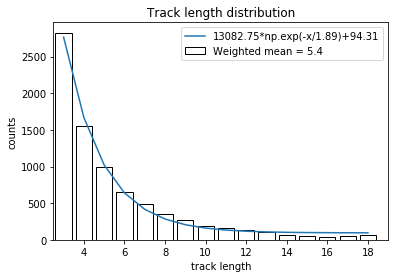

In [27]:
for rep in reps:
    tracklen.get_track_lengths_dist(rep, plot=True)

## 3. Fitting of the jump lengths distribution to the model (2 states)


Number of frames: 1000.0, number of localizations: 48450
Computation of jump lengths performed in 2.48s
Fitting 2 states
Improved fit on iteration 1
Improved error is 2.8712388890862877e-06
Name        Value      Min      Max   Stderr
D_bound         0        0    0.005     None
D_free    0.03599     0.02      0.1     None
F_bound    0.3334        0        1     None
sigma     0.02188    0.005      0.1     None
None


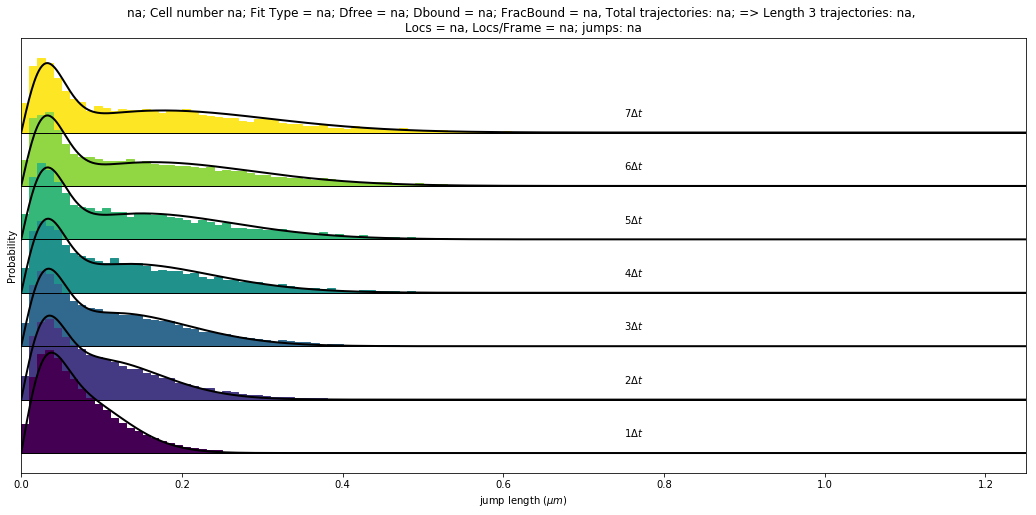

In [28]:
## Generate a dictionary of parameters
fit_params = dict(states=2,
                 iterations=1,
                 CDF=False,
                 CDF1 = True,
                 Frac_Bound = [0, 1],
                 D_Free = [0.02, 0.1],
                 D_Med = [0.005, 0.1],
                 D_Bound = [0.0, 0.005],
                 sigma = 0.02,
                 sigma_bound = [0.005, 0.1],
                 fit_sigma=True,
                 dT=exposure_ms / 1000,
                 dZ=0.7,
                 a=0.15716,
                 b=0.20811,
                 useZcorr=False,
                 plot_hist=False,
                 plot_result=True) 


def my_fit(rep):
    
    cell_spt = readers.to_fastSPT(rep, from_json=False)
    fit_result = tools.auto_fit(cell_spt,
                                fit_params=fit_params)
    return fit_result

reps_fits = list(map(my_fit, reps))


In [29]:
#get stats
fit_stats = pd.DataFrame(columns=list(reps_fits[0].best_values.keys()) + ['chi2', 'num_tracks'])

for i, fit_result in enumerate(reps_fits):
    #name = data_paths[i].split("\\")[-2]
    name = f'rep {i+1}'
    fit_stats.loc[f'{name}'] = list(fit_result.best_values.values()) + [fit_result.chisqr, len(reps[i])]

fit_stats.loc['mean'] = fit_stats.mean(axis=0)
fit_stats.loc['std'] = fit_stats.std(axis=0)


fit_stats

,D_free,D_bound,F_bound,sigma,chi2,num_tracks
rep 1,0.035989,0.0,0.333406,0.021879,0.00253,8170.0
mean,0.035989,0.0,0.333406,0.021879,0.00253,8170.0
std,0.000000,0.0,0.000000,0.000000,0.00000,0.0


In [22]:
# save stats:

fit_stats.to_json(data_path + '.stats.json')

In [58]:
# Save fitting parameters

import json

json.dump(fit_params, open(folder + '/params.json', 'x'))

In [24]:
# Open stats
pd.read_json(data_path + '.stats.json')

,D_free,D_bound,F_bound,sigma,chi2,num_tracks
mean,0.041432,3.528900e-06,0.241580,0.021622,0.004863,2562.000000
rep 1,0.041942,2.220446e-18,0.250612,0.021797,0.007156,1420.000000
rep 2,0.039537,2.117340e-05,0.218074,0.021811,0.003174,3308.000000
rep 3,0.045194,4.440892e-18,0.278994,0.021810,0.007759,1356.000000
rep 4,0.037085,0.000000e+00,0.226210,0.021352,0.003394,2533.000000
rep 5,0.040083,8.881784e-18,0.235391,0.021782,0.002952,3806.000000
rep 6,0.044749,2.775558e-19,0.240199,0.021178,0.004744,2949.000000
std,0.002879,7.890900e-06,0.019623,0.000257,0.001929,914.080777
